# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [91]:
import warnings
warnings.filterwarnings('ignore')

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [92]:
# Load in the general demographics data.
azdias_original = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias = azdias_original.copy()
# Load in the feature summary file.
feat_info_original = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info = feat_info_original.copy()

In [93]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [94]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [95]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
def shapes():
    print('Azdias Shape: {}'.format(azdias.shape))
    print('feat_info Shape: {}'.format(feat_info.shape))

shapes()

Azdias Shape: (891221, 85)
feat_info Shape: (85, 4)


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [96]:
# Check Frist Value Counts before.
azdias.AGER_TYP.value_counts()
# We need to should get rid of "0" and "-1".

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [97]:
# Check Last Value Counts before.
azdias.RELAT_AB.value_counts()
# We need to should get rid of "9" and "-1", but there don't seem to be any "-1" from the start.

3.0    274008
5.0    174964
1.0    142907
2.0    104846
4.0     97121
9.0       159
Name: RELAT_AB, dtype: int64

In [98]:
# Identify missing or unknown data values and convert them to NaNs.
for i, j in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    print("\n {}:".format(i))
    if j == '[]':
        print("Nothing Have been removed.")
        continue
        
    tmp_list = j.replace('[','').replace(']','').split(',')
        
    for k in tmp_list:
        if k != 'X' and k != 'XX':
            azdias[i].replace(int(k), np.nan, inplace = True)
            print('{} has been removed.'.format(k, i))
        else:
            azdias[i].replace(k, np.nan, inplace = True)
            print('{} has been removed.'.format(k, i))


 AGER_TYP:
-1 has been removed.
0 has been removed.

 ALTERSKATEGORIE_GROB:
-1 has been removed.
0 has been removed.
9 has been removed.

 ANREDE_KZ:
-1 has been removed.
0 has been removed.

 CJT_GESAMTTYP:
0 has been removed.

 FINANZ_MINIMALIST:
-1 has been removed.

 FINANZ_SPARER:
-1 has been removed.

 FINANZ_VORSORGER:
-1 has been removed.

 FINANZ_ANLEGER:
-1 has been removed.

 FINANZ_UNAUFFAELLIGER:
-1 has been removed.

 FINANZ_HAUSBAUER:
-1 has been removed.

 FINANZTYP:
-1 has been removed.

 GEBURTSJAHR:
0 has been removed.

 GFK_URLAUBERTYP:
Nothing Have been removed.

 GREEN_AVANTGARDE:
Nothing Have been removed.

 HEALTH_TYP:
-1 has been removed.
0 has been removed.

 LP_LEBENSPHASE_FEIN:
0 has been removed.

 LP_LEBENSPHASE_GROB:
0 has been removed.

 LP_FAMILIE_FEIN:
0 has been removed.

 LP_FAMILIE_GROB:
0 has been removed.

 LP_STATUS_FEIN:
0 has been removed.

 LP_STATUS_GROB:
0 has been removed.

 NATIONALITAET_KZ:
-1 has been removed.
0 has been removed.

 PRAE

In [99]:
# Check First Value Counts After.
azdias.AGER_TYP.value_counts()
# "0" and "-1" are gone now, which means we did right

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

In [100]:
# Check Last Counts After.
azdias.RELAT_AB.value_counts()
# "9" are gone now, which means we did right

3.0    274008
5.0    174964
1.0    142907
2.0    104846
4.0     97121
Name: RELAT_AB, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [101]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print('Number of missing data in each column:')
for i in feat_info['attribute']:
    print("{}: {}".format(i, azdias[i].isna().sum()))

Number of missing data in each column:
AGER_TYP: 685843
ALTERSKATEGORIE_GROB: 2881
ANREDE_KZ: 0
CJT_GESAMTTYP: 4854
FINANZ_MINIMALIST: 0
FINANZ_SPARER: 0
FINANZ_VORSORGER: 0
FINANZ_ANLEGER: 0
FINANZ_UNAUFFAELLIGER: 0
FINANZ_HAUSBAUER: 0
FINANZTYP: 0
GEBURTSJAHR: 392318
GFK_URLAUBERTYP: 4854
GREEN_AVANTGARDE: 0
HEALTH_TYP: 111196
LP_LEBENSPHASE_FEIN: 97632
LP_LEBENSPHASE_GROB: 94572
LP_FAMILIE_FEIN: 77792
LP_FAMILIE_GROB: 77792
LP_STATUS_FEIN: 4854
LP_STATUS_GROB: 4854
NATIONALITAET_KZ: 108315
PRAEGENDE_JUGENDJAHRE: 108164
RETOURTYP_BK_S: 4854
SEMIO_SOZ: 0
SEMIO_FAM: 0
SEMIO_REL: 0
SEMIO_MAT: 0
SEMIO_VERT: 0
SEMIO_LUST: 0
SEMIO_ERL: 0
SEMIO_KULT: 0
SEMIO_RAT: 0
SEMIO_KRIT: 0
SEMIO_DOM: 0
SEMIO_KAEM: 0
SEMIO_PFLICHT: 0
SEMIO_TRADV: 0
SHOPPER_TYP: 111196
SOHO_KZ: 73499
TITEL_KZ: 889061
VERS_TYP: 111196
ZABEOTYP: 0
ALTER_HH: 310267
ANZ_PERSONEN: 73499
ANZ_TITEL: 73499
HH_EINKOMMEN_SCORE: 18348
KK_KUNDENTYP: 584612
W_KEIT_KIND_HH: 147988
WOHNDAUER_2008: 73499
ANZ_HAUSHALTE_AKTIV: 99611
ANZ_

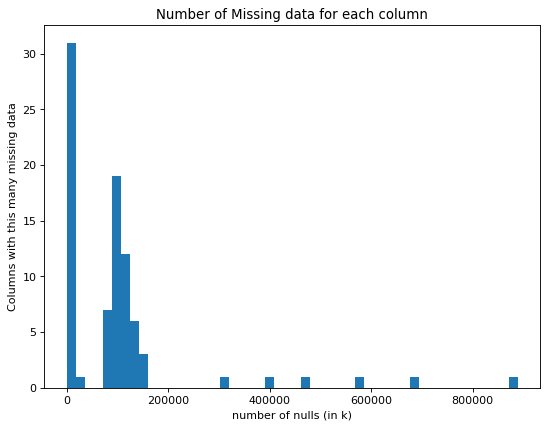

In [102]:
# Investigate patterns in the amount of missing data in each column.

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.hist(azdias.isna().sum(), density=False, bins=50)  # density=False would make counts
plt.title('Number of Missing data for each column')
plt.ylabel('Columns with this many missing data')
plt.xlabel('number of nulls (in k)');

In [103]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
counter = 0

print("Current Shape of 'azdias' {}\nDropping Outliers Columns:\n-----------------------------".format(azdias.shape))
for i in feat_info['attribute']:
    if azdias[i].isna().sum() > 200000:
        print("{} dropped".format(i))
        azdias = azdias.drop([i], axis = 1)
        feat_info = feat_info[~feat_info.attribute.isin([i])]
        counter = counter + 1
print("-----------------------------\nFinished, {} Columns has been dropped\nCurrent Shape of 'azdias' {}".format(counter, azdias.shape))
        

Current Shape of 'azdias' (891221, 85)
Dropping Outliers Columns:
-----------------------------
AGER_TYP dropped
GEBURTSJAHR dropped
TITEL_KZ dropped
ALTER_HH dropped
KK_KUNDENTYP dropped
KBA05_BAUMAX dropped
-----------------------------
Finished, 6 Columns has been dropped
Current Shape of 'azdias' (891221, 79)


In [104]:
outliers = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

#### Discussion 1.1.2: Assess Missing Data in Each Column

### Most columns in dataset have less than 200.000 Missing Values,
### we can consider any column with more than 200.000 an outlier an remove it, means 6 columns has been deleted.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [105]:
# How much data is missing in each row of the dataset?
missingRows = azdias.isna().sum(axis=1)

print('Number of missing data in each row (from 0 to 891220):')
missingRows

Number of missing data in each row (from 0 to 891220):


0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

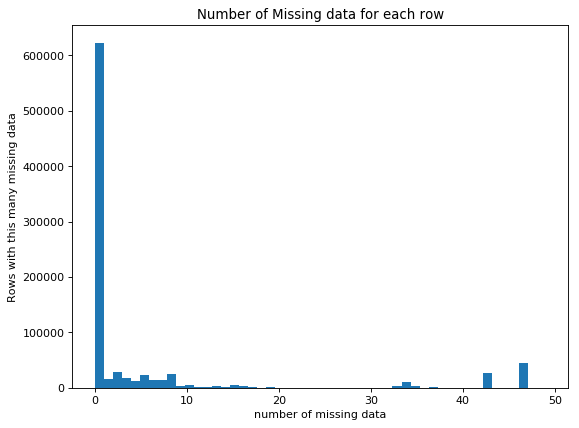

In [106]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.hist(azdias.isnull().sum(axis=1), density=False, bins=50)  # density=False would make counts
plt.title('Number of Missing data for each row')
plt.ylabel('Rows with this many missing data')
plt.xlabel('number of missing data');

In [107]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# the data can be cut in two halves, one with less than 30 missing data and other with more than or equal 30:
# data set with <30k:

azdias_less30 = missingRows[missingRows < 30]

# data set with >=30k:
azdias_more30 = missingRows[missingRows >= 30]

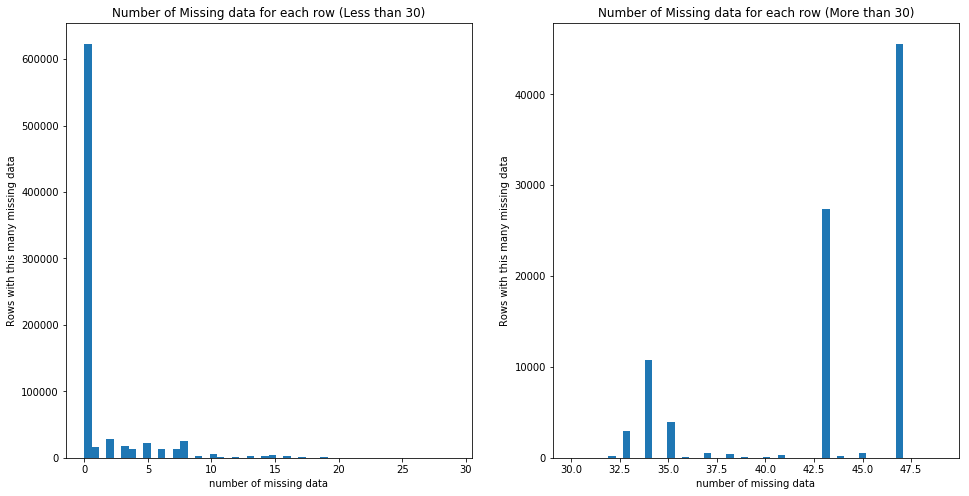

In [108]:
# plot the new datasets, we can see it was divided successfuly.

figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.hist(azdias_less30, density=False, bins=50)
plt.title('Number of Missing data for each row (Less than 30)')
plt.ylabel('Rows with this many missing data')
plt.xlabel('number of missing data');

plt.subplot(1, 2, 2) # index 2
plt.hist(azdias_more30, density=False, bins=50)  # density=False would make counts
plt.title('Number of Missing data for each row (More than 30)')
plt.ylabel('Rows with this many missing data')
plt.xlabel('number of missing data');

Text(0.5,1,'(FINANZTYP) More or equal to 30 Missing')

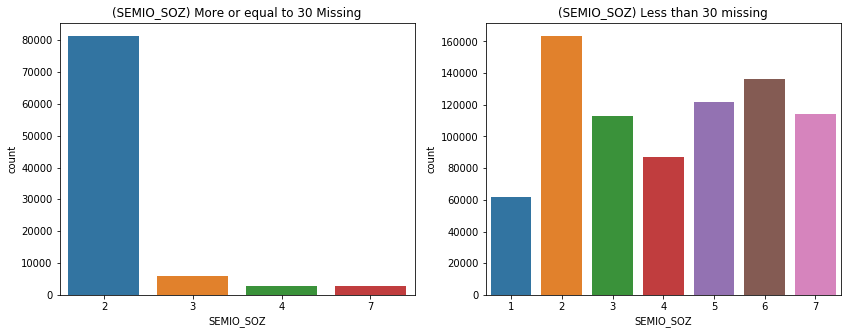

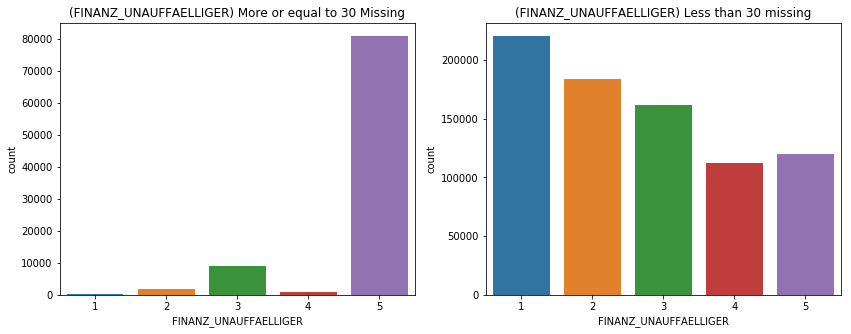

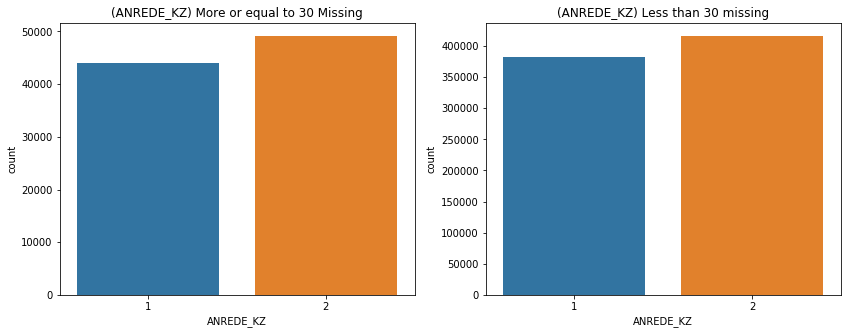

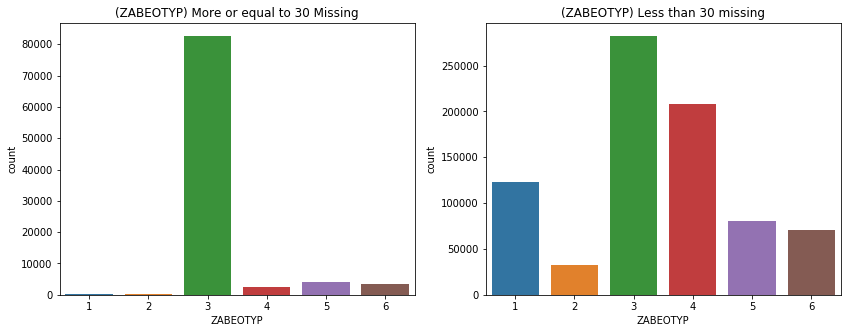

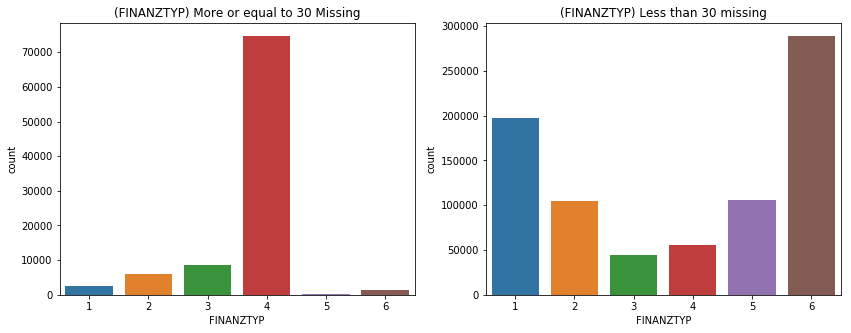

In [109]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# I will Compare the columns : (SEMIO_SOZ, FINANZ_UNAUFFAELLIGER, ANREDE_KZ, ZABEOTYP, FINANZTYP):

# 1- The column "SEMIO_SOZ"
figure(figsize=(14,5))
plt.subplot(1,2,2)
sns.countplot(data = azdias.iloc[azdias_less30.index], x ='SEMIO_SOZ')
plt.title('(SEMIO_SOZ) Less than 30 missing')

plt.subplot(1,2,1)
sns.countplot(data = azdias.iloc[azdias_more30.index], x ='SEMIO_SOZ')
plt.title('(SEMIO_SOZ) More or equal to 30 Missing')

# 2- The column "FINANZ_UNAUFFAELLIGER"
figure(figsize=(14,5))
plt.subplot(1,2,2)
sns.countplot(data = azdias.iloc[azdias_less30.index], x ='FINANZ_UNAUFFAELLIGER')
plt.title('(FINANZ_UNAUFFAELLIGER) Less than 30 missing')

plt.subplot(1,2,1)
sns.countplot(data = azdias.iloc[azdias_more30.index], x ='FINANZ_UNAUFFAELLIGER')
plt.title('(FINANZ_UNAUFFAELLIGER) More or equal to 30 Missing')

# 3- The column "ANREDE_KZ"
figure(figsize=(14,5))
plt.subplot(1,2,2)
sns.countplot(data = azdias.iloc[azdias_less30.index], x ='ANREDE_KZ')
plt.title('(ANREDE_KZ) Less than 30 missing')

plt.subplot(1,2,1)
sns.countplot(data = azdias.iloc[azdias_more30.index], x ='ANREDE_KZ')
plt.title('(ANREDE_KZ) More or equal to 30 Missing')

# 4- The column "ZABEOTYP"
figure(figsize=(14,5))
plt.subplot(1,2,2)
sns.countplot(data=azdias.iloc[azdias_less30.index], x='ZABEOTYP')
plt.title('(ZABEOTYP) Less than 30 missing')

plt.subplot(1,2,1)
sns.countplot(data=azdias.iloc[azdias_more30.index], x='ZABEOTYP')
plt.title('(ZABEOTYP) More or equal to 30 Missing')

# 5- The column "FINANZTYP"
figure(figsize=(14,5))
plt.subplot(1,2,2)
sns.countplot(data=azdias.iloc[azdias_less30.index], x='FINANZTYP')
plt.title('(FINANZTYP) Less than 30 missing')

plt.subplot(1,2,1)
sns.countplot(data=azdias.iloc[azdias_more30.index], x='FINANZTYP')
plt.title('(FINANZTYP) More or equal to 30 Missing')


In [110]:
# Drop high missing rows
print("Shape before dropping high missing rows: {}.".format(azdias.shape))

azdias = azdias.loc[azdias_less30.index,:]

print("Shape after dropping high missing rows: {}.".format(azdias.shape))

Shape before dropping high missing rows: (891221, 79).
Shape after dropping high missing rows: (798061, 79).


#### Discussion 1.1.3: Assess Missing Data in Each Row

### When Checking the missing data in each row I noticed it can be cut in two parts, one with >= 30 missing and other with <30, so I just did that and cheked the,
### then I droppend the part with high missing values from azdias.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [111]:
# How many features are there of each data type?
feat_info.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [112]:
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [113]:
categorical_info = feat_info[feat_info['type'] == 'categorical']
mixed_info = feat_info[feat_info['type'] == 'mixed']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [114]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_info

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [115]:
# Re-encode categorical variable(s) to be kept in the analysis

# First Check the Binary columns and detect the binary column with non-numeric values.
print('Binary Columns:')
for i in categorical_info.attribute:
    if azdias[i].nunique() <= 2:
        if azdias[i].dtype == object:
            #this is to detect the one column with non-numeric values.
            print('{} takes non-numeric values and has {} attributes'.format(i, azdias[i].nunique()))
        else:
            print('{} has {} attributes'.format(i, azdias[i].nunique()))
            
# Second Check the Multi-level columns and drop them from both "azdias" and "feat_info" datasets.
print('-------------------------------\nMulti-level Columns:')
for i in categorical_info.attribute:
    if azdias[i].nunique() > 2:
        print('{} has {} attributes, dropped.'.format(i, azdias[i].nunique()))
        azdias.drop(i, axis='columns', inplace=True)
        feat_info = feat_info[~feat_info.attribute.isin([i])]

Binary Columns:
ANREDE_KZ has 2 attributes
GREEN_AVANTGARDE has 2 attributes
SOHO_KZ has 2 attributes
VERS_TYP has 2 attributes
OST_WEST_KZ takes non-numeric values and has 2 attributes
-------------------------------
Multi-level Columns:
CJT_GESAMTTYP has 6 attributes, dropped.
FINANZTYP has 6 attributes, dropped.
GFK_URLAUBERTYP has 12 attributes, dropped.
LP_FAMILIE_FEIN has 11 attributes, dropped.
LP_FAMILIE_GROB has 5 attributes, dropped.
LP_STATUS_FEIN has 10 attributes, dropped.
LP_STATUS_GROB has 5 attributes, dropped.
NATIONALITAET_KZ has 3 attributes, dropped.
SHOPPER_TYP has 4 attributes, dropped.
ZABEOTYP has 6 attributes, dropped.
GEBAEUDETYP has 7 attributes, dropped.
CAMEO_DEUG_2015 has 9 attributes, dropped.
CAMEO_DEU_2015 has 44 attributes, dropped.


In [116]:
# Cehck shapes of the two datasets
shapes()

Azdias Shape: (798061, 66)
feat_info Shape: (66, 4)


In [117]:
# Check the non-numeric values in OST_WEST_KZ

azdias['OST_WEST_KZ'].value_counts()

# replace them with numeric values (W to 0 and O to 1)

azdias['OST_WEST_KZ'].replace('W', 0, inplace = True)
azdias['OST_WEST_KZ'].replace('O', 1, inplace = True)

In [118]:
# Check values after replacing
azdias['OST_WEST_KZ'].value_counts()

0    629520
1    168541
Name: OST_WEST_KZ, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

First I dropped All the Multi-level Columns from the dataset, then I did the same for feat_info dataset,
after that I looked for the binary columns with non-numeric values, found out it has W and O, then replaced them with 0 and 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [119]:
mixed_info.head()

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [120]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182983
8.0     141630
10.0     85808
5.0      84691
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [121]:
# Function to help making the dacade column column
def decade(value):
    # Check it is not null value.
    if np.isnan(float(value)):
        return np.nan
    
    # 1 and 2 are in 40s
    if value == 1 or value == 2:
        return 40;
        # 3 and 4 are in 50s
    if value == 3 or value == 4:
        return 50;
        # 5, 6 and 7 are in 60s
    if value == 5 or value == 6 or value == 7:
        return 60;
        # 8 and 9 are in 70s
    if value == 8 or value == 9:
        return 70;
        # 10, 11, 12 and 13 are in 80s
    if value == 10 or value == 11 or value == 12 or value == 13:
        return 80;
        # 14 and 15 are in 90s
    if value == 14 or value == 15:
        return 90;
    
# Function to help making the Dominating movement column
def Dominating_movement(value):
    # Check it is not null value.
    if np.isnan(float(value)):
        return np.nan
    
    avantgarde_values = [1, 3, 5, 8, 10, 12, 14]
    mainstream_values = [2, 4, 6, 7, 9, 11, 13, 15]
        
    for i in avantgarde_values:
        if value == i:
            return 0;
    return 1;

# add two new columns
azdias['PRAEGENDE_JUGENDJAHRE_Dominating_movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(Dominating_movement)
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(decade)

In [122]:
# add them to feat info
feat_info = feat_info.append({'attribute': 'PRAEGENDE_JUGENDJAHRE_Dominating_movement', 'information_level': 'NAN', 'missing_or_unknown': 'NAN'} , ignore_index = True)
feat_info = feat_info.append({'attribute': 'PRAEGENDE_JUGENDJAHRE_DECADE', 'information_level': 'NAN', 'missing_or_unknown': 'NAN'} , ignore_index = True)

In [123]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91157
14     62884
43     56672
54     45391
25     39626
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [124]:
# Function to help making the wealth column
def Wealth(value):
    if (not np.isnan(float(value))):
        return str(value)[0]
    return np.nan

# Function to help making the Life stage typology column
def Life_Stage_Typology(value):
    if (not np.isnan(float(value))):
        return str(value)[1]
    return np.nan
                 
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(Wealth)
azdias['CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY'] = azdias['CAMEO_INTL_2015'].apply(Life_Stage_Typology)

In [125]:
# add them to feat info
feat_info = feat_info.append({'attribute': 'CAMEO_INTL_2015_WEALTH', 'information_level': 'NAN', 'missing_or_unknown': 'NAN'}, ignore_index=True)
feat_info = feat_info.append({'attribute': 'CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY', 'information_level': 'NAN', 'missing_or_unknown': 'NAN'}, ignore_index=True)

In [126]:
# Check all columns has been added correctly
azdias['PRAEGENDE_JUGENDJAHRE_Dominating_movement'].value_counts()

0.0    594081
1.0    175225
Name: PRAEGENDE_JUGENDJAHRE_Dominating_movement, dtype: int64

In [127]:
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts()

90.0    225530
70.0    175200
80.0    151770
60.0    114353
50.0     74296
40.0     28157
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64

In [128]:
azdias['CAMEO_INTL_2015_WEALTH'].value_counts()

5    223582
2    190687
4    189960
1    119442
3     68192
Name: CAMEO_INTL_2015_WEALTH, dtype: int64

In [129]:
azdias['CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY'].value_counts()

1    245053
4    232776
3    119692
5    117043
2     77299
Name: CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY, dtype: int64

In [130]:
# drop the original columns from the dataframe
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'] , axis = 1)
# drop from feat_info column
feat_info = feat_info[~feat_info.attribute.isin(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])]

#### Discussion 1.2.2: Engineer Mixed-Type Features

- I divided 'PRAEGENDE_JUGENDJAHRE' column into two columns, one takes the Dominating movement and other takes the decade.
- I divided 'CAMEO_INTL_2015' column into two columns, one takes the welath and other takes Life stage typology
- I dropped the two original columns from the dataset

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [131]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# check if new row was was added successfuly.
feat_info.tail()

,attribute,information_level,type,missing_or_unknown
65,RELAT_AB,community,ordinal,"[-1,9]"
66,PRAEGENDE_JUGENDJAHRE_Dominating_movement,NAN,NaN,NAN
67,PRAEGENDE_JUGENDJAHRE_DECADE,NAN,NaN,NAN
68,CAMEO_INTL_2015_WEALTH,NAN,NaN,NAN
69,CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY,NAN,NaN,NAN


In [132]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Check the new shapes
shapes()

Azdias Shape: (798061, 68)
feat_info Shape: (68, 4)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [133]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
        
    print('converting missing or unknown values into Nans...')
    # Identify missing or unknown data values and convert them to NaNs.
    for i, j in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if j == '[]':
            continue
        
        tmp_list = j.replace('[','').replace(']','').split(',')
        
        for k in tmp_list:
            if k != 'X' and k != 'XX':
                df[i].replace(int(k), np.nan, inplace = True)
            else:
                df[i].replace(k, np.nan, inplace = True)
    print("Finished.\n----------------------------------------------------------")
    
    # remove outliers columns
    print('Dropping outlier columns...')
    
    counter = 0
    for i in outliers:
        print("{} dropped".format(i))
        df = df.drop([i], axis = 1)
        feat_info = feat_info[~feat_info.attribute.isin([i])]
        counter = counter + 1

    print("-----------------------------\nFinished, {} Columns has been dropped\nCurrent Shape of 'azdias' {}".format(counter, df.shape))
    
    # remove rows with 30 or more missing values
    print('Dropping rows with 30 or more missing values...')
    missingRows = df.isna().sum(axis=1)
    azdias_less30 = missingRows[missingRows < 30]
        
    df = df.loc[azdias_less30.index,:]
    feat_info_missing = feat_info
    print("-----------------------------\nFinished, Current Shape of 'azdias' {}".format(df.shape))
    
    print('Dropping rows with more than 30 or more missing values...')   
    # replace OST_WEST_KZ values with numeric values (W to 0 and O to 1)
    df['OST_WEST_KZ'].replace('W', 0, inplace = True)
    df['OST_WEST_KZ'].replace('O', 1, inplace = True)
    
    # drop other catagorical.
    categorical_info = feat_info_missing[feat_info['type'] == 'categorical']

    for i in categorical_info.attribute:
        if df[i].nunique() > 2:
            df.drop(i, axis = 1, inplace=True)
            feat_info_missing = feat_info_missing[~feat_info.attribute.isin([i])]
    
    # add two new columns from "PRAEGENDE_JUGENDJAHRE"
    df['PRAEGENDE_JUGENDJAHRE_Dominating_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(Dominating_movement)
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    
    # add two new columns from "CAMEO_INTL_2015"
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(Wealth)
    df['CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY'] = df['CAMEO_INTL_2015'].apply(Life_Stage_Typology)
    
    # Drop all mixed features from our dataset including PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    df = df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'] , axis = 1)
    print("-----------------------------\nFinished, Current Shape of 'azdias' {}".format(df.shape))
    print("Dataset has been cleaned successfuly.")

    return df

In [134]:
# test the function
new_azdias = azdias_original
new_feat_info = feat_info_original

new_azdias = clean_data(new_azdias, new_feat_info)

converting missing or unknown values into Nans...
Finished.
----------------------------------------------------------
Dropping outlier columns...
AGER_TYP dropped
GEBURTSJAHR dropped
TITEL_KZ dropped
ALTER_HH dropped
KK_KUNDENTYP dropped
KBA05_BAUMAX dropped
-----------------------------
Finished, 6 Columns has been dropped
Current Shape of 'azdias' (891221, 79)
Dropping rows with 30 or more missing values...
-----------------------------
Finished, Current Shape of 'azdias' (798061, 79)
Dropping rows with more than 30 or more missing values...
-----------------------------
Finished, Current Shape of 'azdias' (798061, 68)
Dataset has been cleaned successfuly.


In [135]:
# Check the new data
new_azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB                         795258 non-null float64
ANREDE_KZ                                    798061 non-null int64
FINANZ_MINIMALIST                            798061 non-null int64
FINANZ_SPARER                                798061 non-null int64
FINANZ_VORSORGER                             798061 non-null int64
FINANZ_ANLEGER                               798061 non-null int64
FINANZ_UNAUFFAELLIGER                        798061 non-null int64
FINANZ_HAUSBAUER                             798061 non-null int64
GREEN_AVANTGARDE                             798061 non-null int64
HEALTH_TYP                                   761340 non-null float64
LP_LEBENSPHASE_FEIN                          747828 non-null float64
LP_LEBENSPHASE_GROB                          750721 non-null float64
RETOURTYP_BK_S                               793316 non-null float64
SEMIO_SO

In [136]:
new_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Dominating_movement,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,90.0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,1.0,90.0,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,0.0,70.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0.0,70.0,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,50.0,5,4


In [137]:
new_azdias.shape

(798061, 68)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [138]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

new_azdias = pd.DataFrame(Imputer(missing_values=np.nan, strategy='mean', axis=1).fit_transform(new_azdias),
                          columns=new_azdias.keys())
new_azdias.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False], dtype=bool)

In [139]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
new_azdias = pd.DataFrame(scaler.fit_transform(new_azdias), columns=new_azdias.keys())

### Discussion 2.1: Apply Feature Scaling

- I removed the NAN values from the dataset using Imputer.
- using StandardScaler I scaled the dataset values.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [140]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA().fit(new_azdias)

In [141]:
# using a method we used in the class room

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''

    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
def Variance_Explained(pca):
    num_components=len(pca.explained_variance_ratio_)
    vals = pca.explained_variance_ratio_

    a = 0
    for i in range(num_components):
        a = a + vals[i]*100
    return '{:.2f}'.format(a) + '%'



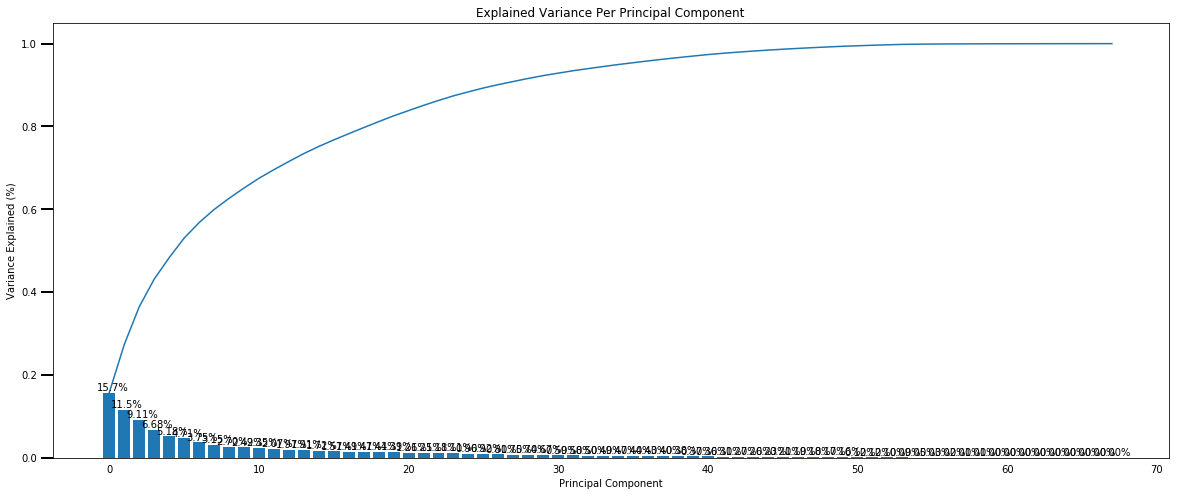

In [142]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [143]:
# to Check Variance Explained method, it should get 100% since it is the full data.
Variance_Explained(pca)

'100.00%'

In [144]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca2 = PCA(n_components = 15).fit(new_azdias)

In [145]:
# to see Variance Explained in percent.
Variance_Explained(pca2)

'75.17%'

### Discussion 2.2: Perform Dimensionality Reduction

- using only n_components = 15, we can get Variance Explained up to 75.16%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [146]:
# when 'getTail' is true it will give top 10 lest weight, else it will give top 10 most weights
def weight_results(df, pca, principal_component, getTail):
    
    if getTail:
        mostLeast = 'Least'
    else:
        mostLeast = 'Most'
        
    print('{} 10 weighted for component {}:'.format(mostLeast, principal_component))
    
    components = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[principal_component - 1]
    components = components.sort_values(ascending = getTail)
    components = pd.concat([components.head(10)])
        
    return components

In [147]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

weight_results(new_azdias, pca2, 1, False)

Most 10 weighted for component 1:


KBA05_GBZ      0.2615
MOBI_REGIO     0.2613
KBA05_ANTG1    0.2608
KBA05_ANTG2    0.2593
KBA05_ANTG4    0.2593
KBA05_ANTG3    0.2586
PLZ8_GBZ       0.2575
PLZ8_ANTG1     0.2572
PLZ8_HHZ       0.2541
PLZ8_ANTG4     0.2519
Name: 0, dtype: float64

In [148]:
weight_results(new_azdias, pca2, 1, True)

Least 10 weighted for component 1:


FINANZ_HAUSBAUER      -0.0907
HH_EINKOMMEN_SCORE    -0.0721
SEMIO_LUST            -0.0500
WOHNDAUER_2008        -0.0475
ANZ_HAUSHALTE_AKTIV   -0.0312
EWDICHTE              -0.0309
FINANZ_VORSORGER      -0.0308
ORTSGR_KLS9           -0.0304
SEMIO_ERL             -0.0255
SEMIO_DOM             -0.0244
Name: 0, dtype: float64

In [149]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight_results(new_azdias, pca2, 2, False)

Most 10 weighted for component 2:


SEMIO_REL                       0.3008
FINANZ_SPARER                   0.2850
SEMIO_KULT                      0.2640
SEMIO_PFLICHT                   0.2637
PRAEGENDE_JUGENDJAHRE_DECADE    0.2525
SEMIO_TRADV                     0.2513
SEMIO_FAM                       0.2363
FINANZ_UNAUFFAELLIGER           0.2311
FINANZ_ANLEGER                  0.2026
SEMIO_MAT                       0.1992
Name: 1, dtype: float64

In [150]:
weight_results(new_azdias, pca2, 2, True)

Least 10 weighted for component 2:


SEMIO_ERL              -0.2669
FINANZ_VORSORGER       -0.2641
SEMIO_LUST             -0.1908
FINANZ_MINIMALIST      -0.1778
SEMIO_KRIT             -0.1299
ANREDE_KZ              -0.1144
ALTERSKATEGORIE_GROB   -0.1122
SEMIO_KAEM             -0.1120
WOHNDAUER_2008         -0.0818
SEMIO_DOM              -0.0807
Name: 1, dtype: float64

In [151]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight_results(new_azdias, pca2, 3, False)

Most 10 weighted for component 3:


SEMIO_VERT           0.3400
FINANZ_MINIMALIST    0.2507
SEMIO_SOZ            0.2248
SEMIO_KULT           0.1996
SEMIO_FAM            0.1994
FINANZ_VORSORGER     0.1182
GREEN_AVANTGARDE     0.0896
KONSUMNAEHE          0.0744
INNENSTADT           0.0622
ANZ_PERSONEN         0.0604
Name: 2, dtype: float64

In [152]:
weight_results(new_azdias, pca2, 3, True)

Least 10 weighted for component 3:


ANREDE_KZ            -0.3427
SEMIO_KAEM           -0.3346
SEMIO_DOM            -0.2997
SEMIO_KRIT           -0.2647
SEMIO_RAT            -0.2226
FINANZ_ANLEGER       -0.1731
SEMIO_ERL            -0.1472
FINANZ_HAUSBAUER     -0.1464
FINANZ_SPARER        -0.1432
HH_EINKOMMEN_SCORE   -0.1278
Name: 2, dtype: float64

### Discussion 2.3: Interpret Principal Components

***Using the method 'weight_results' I was able to get the most and least 10 weighted feature for each principal component.***


***For principal component 1:***

this component looks related the most to Number of buildings in the microcell, Movement patterns and Number of family houses in the microcell, of course there are more but these are the top.

and looks related less to home ownership Financiality, Estimated household net income and sensual-minded Personality, of course there are more but these are the top.

***For principal component 2:***

this component looks related the most to religious Personality, money-saver Financiality and cultural-minded Personality, of course there are more but these are the top.

and looks related less to event-oriented Personality, 'be prepared' Financiality and sensual-minded Personality, of course there are more but these are the top.

***For principal component 3:***

this component looks related the most to dreamful Personality, low financial interest Financiality and socially-minded Personality, of course there are more but these are the top.

and looks related less to Gender, combative attitude Personality and dominant-minded Personality, of course there are more but these are the top.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [153]:
from sklearn.cluster import KMeans

In [154]:
pca3 = PCA(n_components = 15)
pca3_fitTransform = pca3.fit_transform(new_azdias)

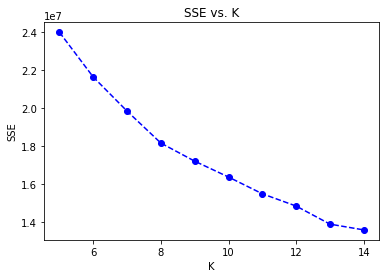

In [73]:
# Note: This cell takes sometime to compile.

# using the method from the classroom.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(5,15))

for center in centers:
    scores.append(get_kmeans_score(pca3_fitTransform, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [155]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model = KMeans(n_clusters = 8).fit(pca3_fitTransform)
predict_azdias = model.predict(pca3_fitTransform)

### Discussion 3.1: Apply Clustering to General Population

**Using the method 'get_kmeans_score', I calculated the scores and plot it using matplotlib,
Elbow Method, I decided that n_clusters = 8 is the best choice for our model.**

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [156]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', ';')

In [157]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [158]:
customers.shape

(191652, 85)

In [159]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers, feat_info_original)

converting missing or unknown values into Nans...
Finished.
----------------------------------------------------------
Dropping outlier columns...
AGER_TYP dropped
GEBURTSJAHR dropped
TITEL_KZ dropped
ALTER_HH dropped
KK_KUNDENTYP dropped
KBA05_BAUMAX dropped
-----------------------------
Finished, 6 Columns has been dropped
Current Shape of 'azdias' (191652, 79)
Dropping rows with 30 or more missing values...
-----------------------------
Finished, Current Shape of 'azdias' (141725, 79)
Dropping rows with more than 30 or more missing values...
-----------------------------
Finished, Current Shape of 'azdias' (141725, 68)
Dataset has been cleaned successfuly.


In [160]:
customers.shape

(141725, 68)

In [161]:
# fill nan values.
customers = pd.DataFrame(Imputer(missing_values=np.nan, strategy='mean', axis=1).fit_transform(customers),
                          columns=customers.keys())
customers.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False], dtype=bool)

In [162]:
customers.shape

(141725, 68)

In [163]:
#scale values
#customers_scaled = scaler.transform(customers)
customers_scaled = pd.DataFrame(scaler.transform(customers), columns=customers.keys())

In [164]:
customers_scaled

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_Dominating_movement,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE_TYPOLOGY
0,0.381364,-1.043935,1.409057,-1.155518,1.138172,-1.249985,-0.470407,-0.791205,1.885336,-0.348581,...,-0.287803,0.015933,0.045558,-0.765554,-0.970402,-0.703325,-0.099987,-1.459082,-0.668142,-0.048551
1,0.381364,0.957914,1.409057,-1.155518,1.138172,-1.249985,0.958645,0.629141,1.885336,-0.238842,...,-0.033147,-0.250503,-0.351113,-0.122330,-0.136680,-0.087782,-0.099987,-1.459082,-0.149211,0.208315
2,0.381364,-1.043935,1.409057,-1.155518,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.238842,...,-0.287803,-0.250503,-0.086666,-0.765554,-0.692494,-0.703325,-0.218342,-2.113275,-0.408676,0.208315
3,0.019338,-1.043935,-0.042768,-1.155518,0.411884,0.786978,1.673172,-0.791205,-0.530409,-0.129102,...,-0.160475,-0.250503,-0.218889,-0.122330,-0.136680,-0.703325,-0.218342,-0.150694,0.110255,-0.562284
4,0.019338,-1.043935,1.409057,-1.155518,1.138172,-1.249985,-0.470407,-0.081032,1.885336,-0.129102,...,-0.287803,0.015933,0.045558,-0.122330,0.419134,0.527761,-0.099987,-1.459082,-0.149211,0.208315
5,0.381364,-1.043935,1.409057,-1.155518,1.138172,-1.249985,-1.184933,-0.791205,1.885336,-0.238842,...,-0.287803,0.015933,0.045558,-0.443942,-0.692494,-0.395553,-0.099987,-1.459082,-0.408676,-0.048551
6,0.381364,-1.043935,1.409057,-1.155518,1.138172,-1.249985,-0.470407,-0.791205,1.885336,-0.348581,...,-0.287803,-0.250503,-0.218889,-0.122330,-0.414587,-0.087782,-0.099987,-1.459082,-0.668142,0.465181
7,0.381364,0.957914,-0.768681,-0.482158,1.138172,-1.249985,-1.184933,1.339314,-0.530409,-0.238842,...,0.221509,0.015933,-0.086666,-0.122330,0.697042,-0.087782,-0.218342,-2.113275,0.369720,0.465181
8,0.019338,-1.043935,1.409057,-0.482158,0.411884,-1.249985,0.244119,-1.501377,1.885336,-0.129102,...,-0.287803,0.015933,0.045558,-0.122330,0.141227,0.219989,-0.099987,-0.150694,-0.668142,0.465181
9,0.381364,-1.043935,1.409057,-1.155518,1.138172,-1.249985,0.244119,-0.791205,1.885336,-0.348581,...,-0.287803,-0.250503,-0.218889,-0.443942,-0.136680,-0.703325,-0.099987,-1.459082,-0.668142,0.208315


In [165]:
customers_scaled.shape

(141725, 68)

In [166]:
pca_customers = pca3.transform(customers_scaled)


In [167]:
customers_predict = model.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

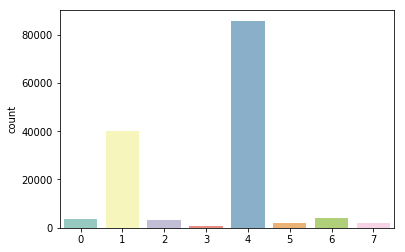

In [168]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
ax = sns.countplot(customers_predict, palette="Set3")

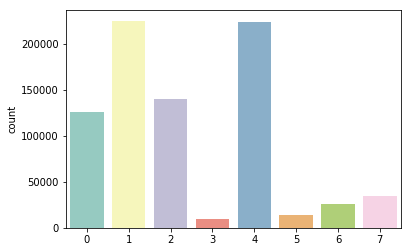

In [169]:
sns.countplot(predict_azdias, palette="Set3")

In [172]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
weight_results(new_azdias, pca2, 0, False)

Most 10 weighted for component 0:


EWDICHTE               0.4532
BALLRAUM               0.4342
INNENSTADT             0.4014
ANZ_PERSONEN           0.2732
KBA13_ANZAHL_PKW       0.1699
WOHNDAUER_2008         0.1522
LP_LEBENSPHASE_FEIN    0.1340
ANZ_HAUSHALTE_AKTIV    0.1209
ANZ_TITEL              0.1198
REGIOTYP               0.1179
Name: 14, dtype: float64

In [173]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
weight_results(new_azdias, pca2, 2, False)

Most 10 weighted for component 2:


SEMIO_REL                       0.3008
FINANZ_SPARER                   0.2850
SEMIO_KULT                      0.2640
SEMIO_PFLICHT                   0.2637
PRAEGENDE_JUGENDJAHRE_DECADE    0.2525
SEMIO_TRADV                     0.2513
SEMIO_FAM                       0.2363
FINANZ_UNAUFFAELLIGER           0.2311
FINANZ_ANLEGER                  0.2026
SEMIO_MAT                       0.1992
Name: 1, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

**1- as we can see the cluster 0 are overrepresented cluster compared to the general population,**

this cluster looks related the most to Density of households(per km^2), Distance to nearest urban center, and Distance to city center, of course there are more but these are the top.

**2- while the 5th cluster are underrepresented cluster, looking at the kinds of people in the cluster we can see that the company are unpopular with 'VERS_TYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_GROB' and many others.**

this cluster looks related the most to religious personality, low financial interest Financiality, and cultural-minded Personality, of course there are more but these are the top.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.